# Experiments with `PyFlux` and ARIMA

I'm pretty ignorant with ARIMA and time series. Below I make some dummy data to try to understand what's going on. I'd love a critque.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
import statsmodels.tsa.api as smt
import pyflux as pf

%matplotlib inline

## Watermark to show my environment's versions

You can install https://github.com/rasbt/watermark with `pip install watermark`, you don't need it to run this Notebook but knowing you have the same environment will make things reproducible.

In [2]:
%load_ext watermark
%watermark -i -v -m -p pyflux,sklearn,scipy,seaborn,pandas,matplotlib,statsmodels -w

2016-11-03T13:40:41+00:00

CPython 3.5.2
IPython 5.1.0

pyflux 0.4.0
sklearn 0.18
scipy 0.18.1
seaborn 0.7.1
pandas 0.19.0
matplotlib 1.5.3
statsmodels 0.6.1

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.8.1-040801-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
watermark 1.3.4


## Make some dummy data

Create a sin wave, below we can optionally add a vertical offset, noise or a trend. Feel free to add these if you're experimenting

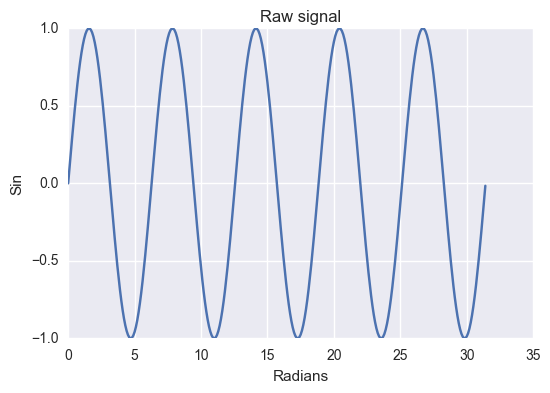

In [3]:
# Build sin wave example
CYCLES = 5 # nbr repeats of each sin wave
STEP_SIZE = 0.1 # granularity - small steps reduces the Trend and Residual values further below (but increase calculation time)
MAX_VALUE_PER_CYCLE = np.pi * 2
x = np.arange(0, MAX_VALUE_PER_CYCLE * CYCLES, STEP_SIZE)
y_clean = pd.Series(np.sin(x))

plt.plot(x, y_clean)
plt.title("Raw signal")
plt.ylabel("Sin")
_=plt.xlabel("Radians")

### User-tunable settings to add noise or a trend

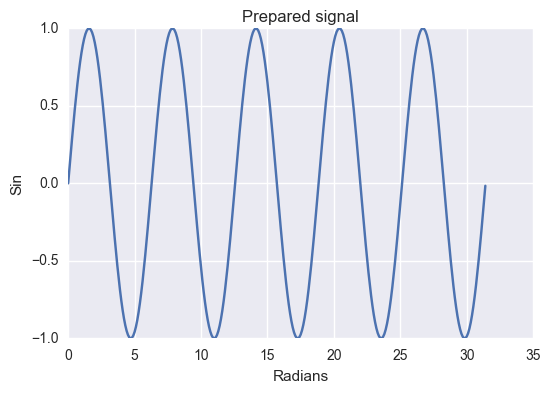

In [4]:
noise = np.random.normal(scale=0.05, size=x.shape[0])
y_offset = 5

# as a baseline we use a sin wave in a Series
y = pd.Series(y_clean)

# we can add a constant offset
#y += y_offset

# we can optionally add noise
#y += noise

# we can optionally add a trend
USING_TREND = False
if USING_TREND:
    # linearly increasing values as x increases
    trend = np.linspace(0, 3, num=x.shape[0])
    y += trend

plt.plot(x, y)
plt.title("Prepared signal")
plt.ylabel("Sin")
_=plt.xlabel("Radians")

## Run Chart

The data is stationery if the data-over-time is balanced around the mean: https://en.wikipedia.org/wiki/Run_chart

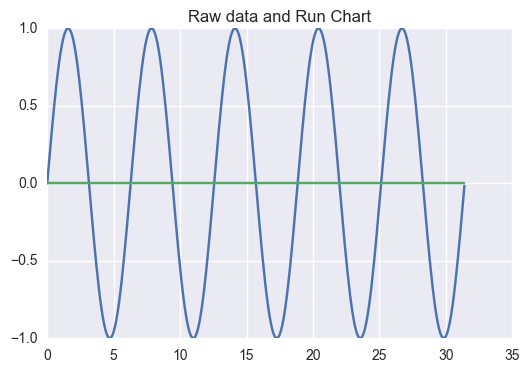

In [5]:
plt.plot(x, y)
y_mean = np.mean(y)
y_means = np.asarray(y_mean) * np.ones(y.shape[0])
plt.plot(x, y_means)
_ = plt.title("Raw data and Run Chart")

### Seasonality plot

`freq` set to `2*pi*nbr_steps`, it is the frequency of our 'season' in this test dataset.

If we have a simple sin wave then the `Trend` has small values (essentially flat wrt the original data) and the `Seasonal` component recovers the original sin wave. The `Residual` will also be tiny.

If `USING_TREND` is `True` then we'll additionally see the linear trend.

/home/ian/anaconda3/envs/rossmann/lib/python3.5/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


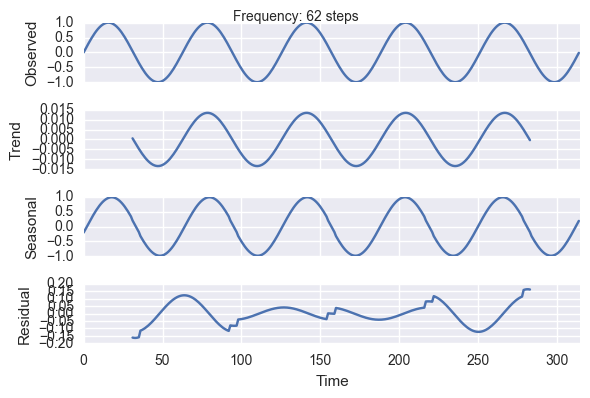

In [6]:
freq = int(MAX_VALUE_PER_CYCLE/STEP_SIZE)
smt.seasonal_decompose(y.values, freq=freq).plot()
_=plt.suptitle("Frequency: {} steps".format(freq))

### Lag plot

Lag plots will show structure if non-random behaviour exists: http://pandas.pydata.org/pandas-docs/version/0.18.1/visualization.html#lag-plot

Note that if the step size is really small then we get a straight line, with larger (0.1) step sizes we get a slightly halo, this is an artefact of the step sizes.

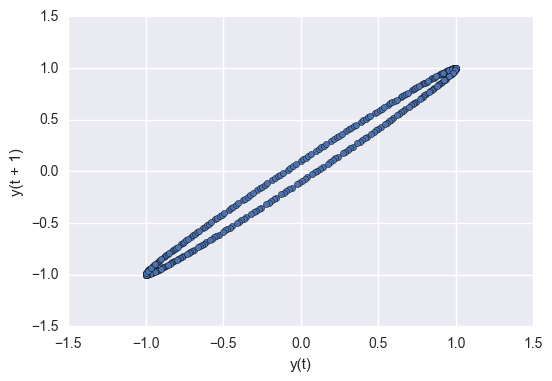

In [7]:
_=lag_plot(y_clean)

### Lag plot on `noise` as a contrast

No structure shown on pure Gaussian noise.

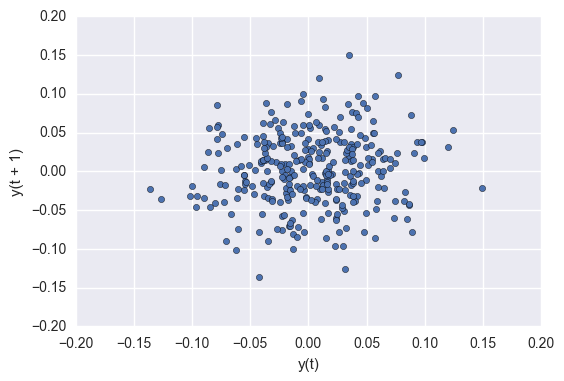

In [8]:
_=lag_plot(pd.Series(noise))

### Autocorrelation plot

As noted https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins#Autocorrelation_and_partial_autocorrelation_plots "Alternating positive and negative, decaying to zero -> Autoregressive model. Use the partial autocorrelation plot to help identify the order."

Without a trend we see a decreasing exponential trend.

With a trend we see a rapidly decreasing set of periods with a weird wiggle.

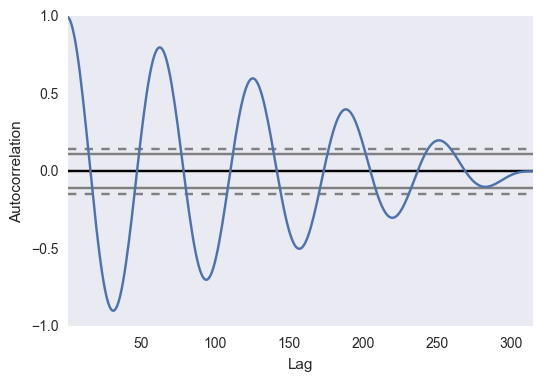

In [9]:
_=autocorrelation_plot(y)

In [10]:
# Taken from "Autocorrelation" section of https://tomaugspurger.github.io/modern-7-timeseries.html

def tsplot(y, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    # NOTE mod by Ian, xlim was (1.5), now set to (0.5) to show self-correlation with no lag (i.e. 1
    # in the following charts) - purely to improve Ian's ignorance
    [ax.set_xlim(0.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

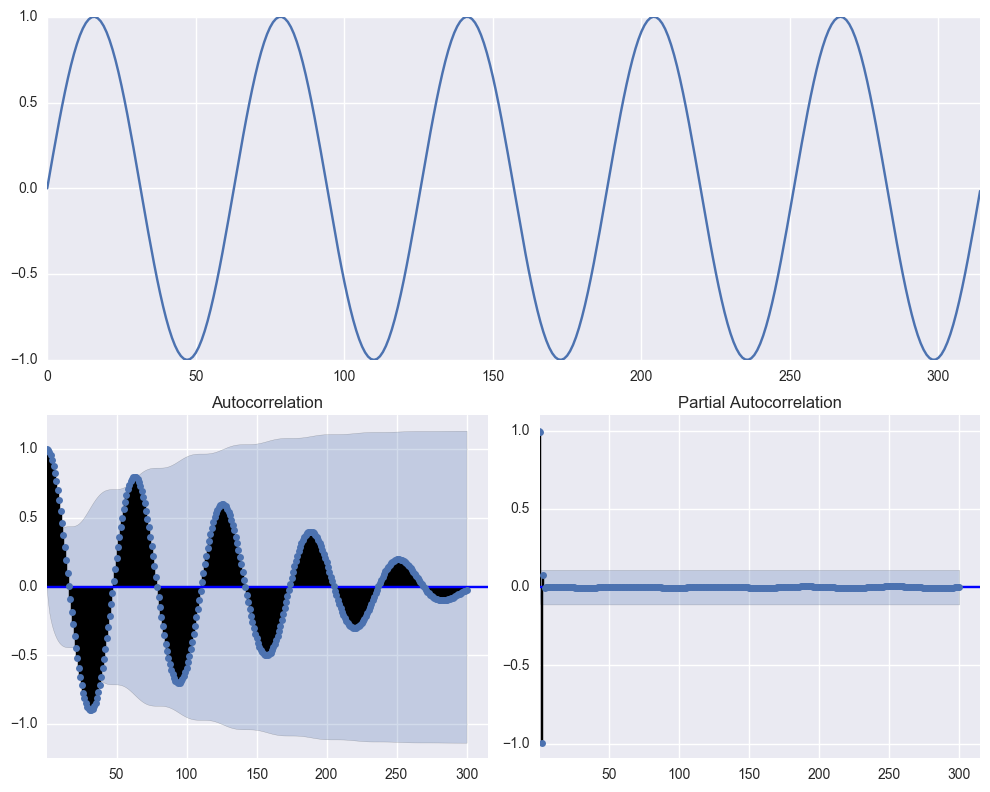

In [11]:
_=tsplot(y, lags=300) 

### Focus on the early components

With a clean sin wave (no noise, no trend) we see a PACF spike at 1 and 2. 1 means each point is correlated with itself, 2 means there's an interdependence between consecutive points. Since all following points show a weaker interdependence PACF essentially zeros their values (as there's no other relationship in this data).

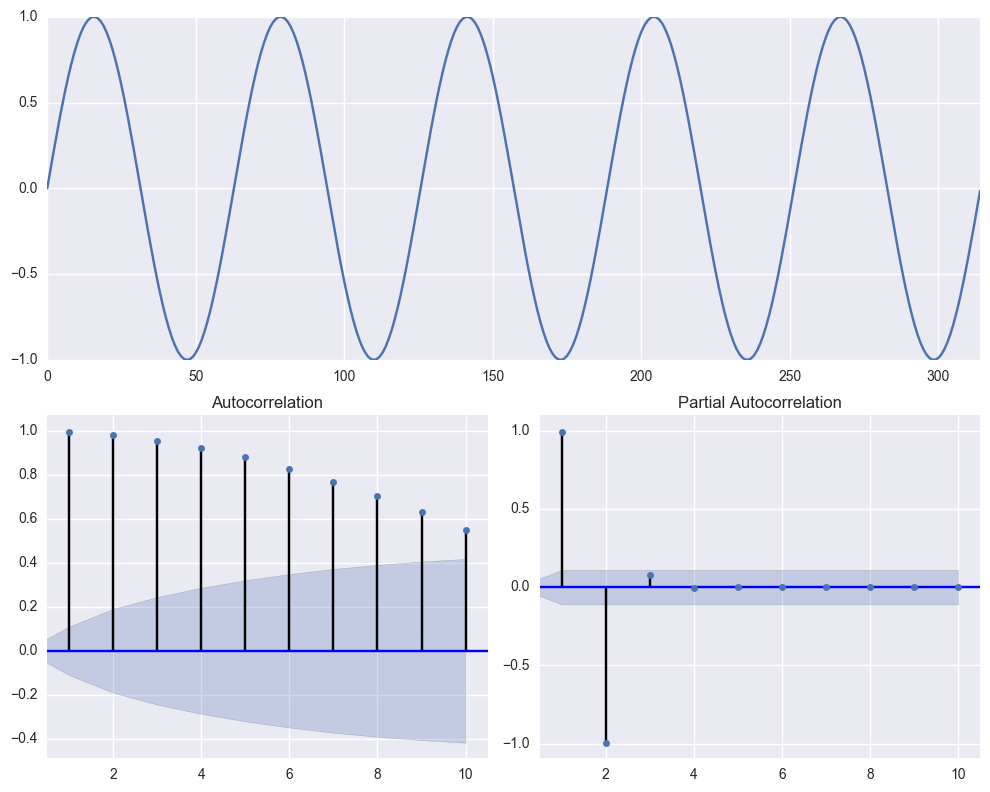

In [12]:
_=tsplot(y, lags=10)

### Build ARIMA model - `AR`

We build an auto-regressive-only (AR only) model using the order identified in the PACF plot (the next largest value after 1, outside of the NH region).

* `ar == p == autoregressive`
* `ma == q == moving average lags`
* `integ == d == differencing`

With a sin wave (no trend, no noise) and `ar=1` we get a 1-step lagged model. With `ar=2` we get a no-lag model (i.e. perfect fit).

With a noisy sin wave (no trend) we need `ar=3`, with `ar=2` the model is lagged by one step. `3` is the largest value in the previous PACF plot when noise is added.

ARIMA(2,0,0)                                                                                              
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 2                                           Log Likelihood: 4843.1165                         
End Date: 314                                           AIC: -9678.2331                                   
Number of observations: 313                             BIC: -9663.2483                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 -0.0       0.0        -2.1829  0.029    (-0.0 | -0.0)            
AR(1)                                

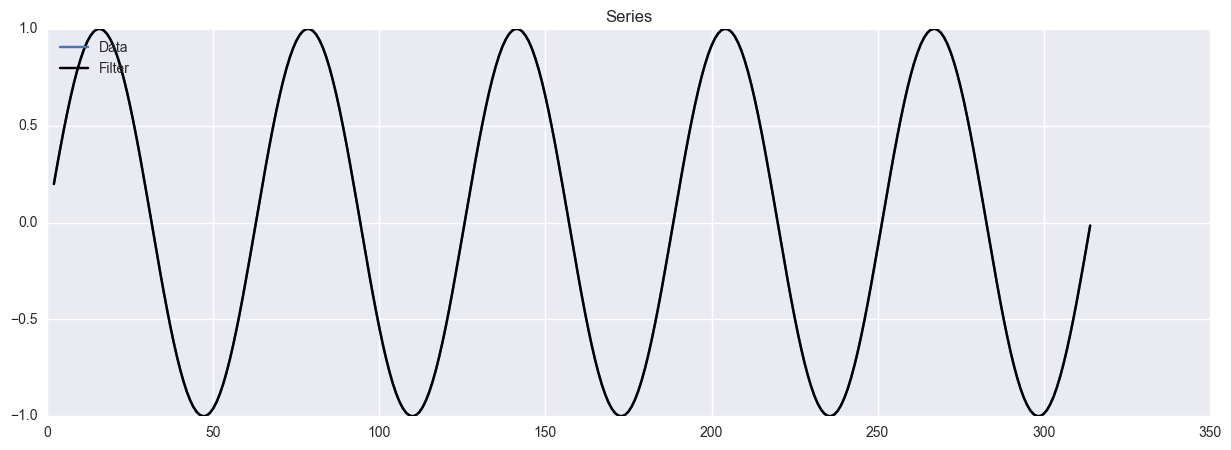

/home/ian/anaconda3/envs/rossmann/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


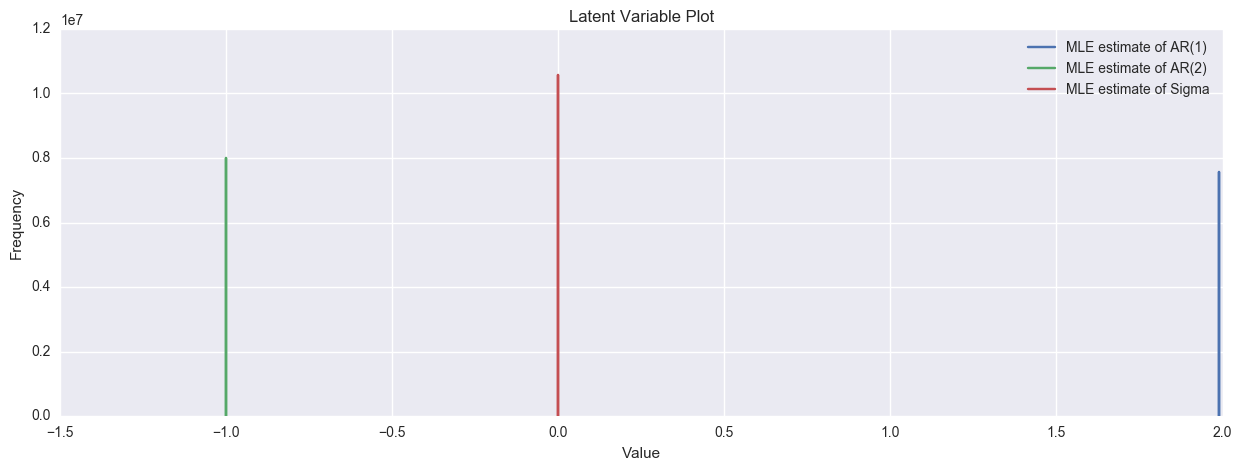

In [13]:
model = pf.ARIMA(data=y.values,ar=2,ma=0,integ=0)
fitted = model.fit()
fitted.summary()

model.plot_fit(figsize=(15,5))

model.plot_z(indices=range(1,9))

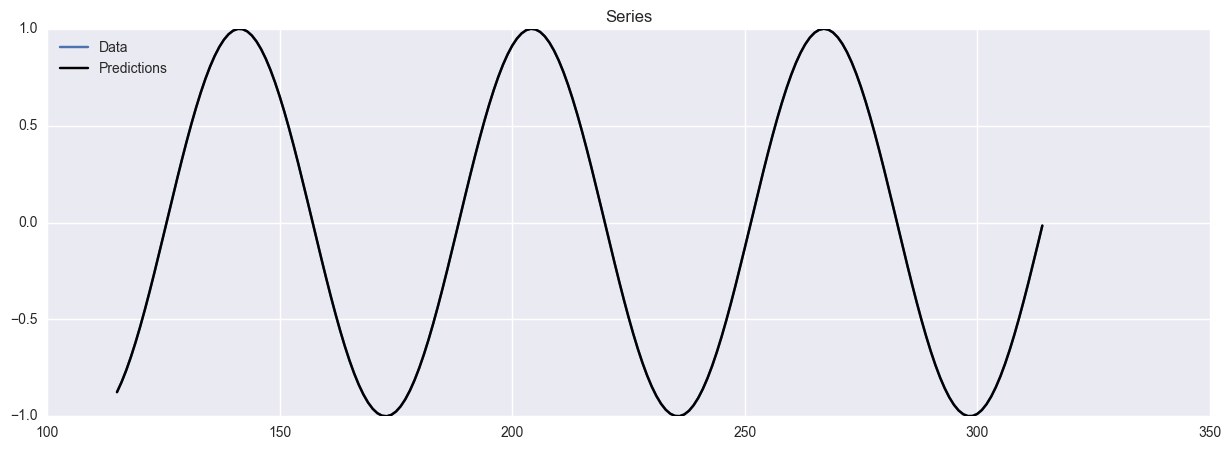

In [14]:
model.plot_predict_is(h=200,figsize=(15,5)) # in-sample rolling predictions

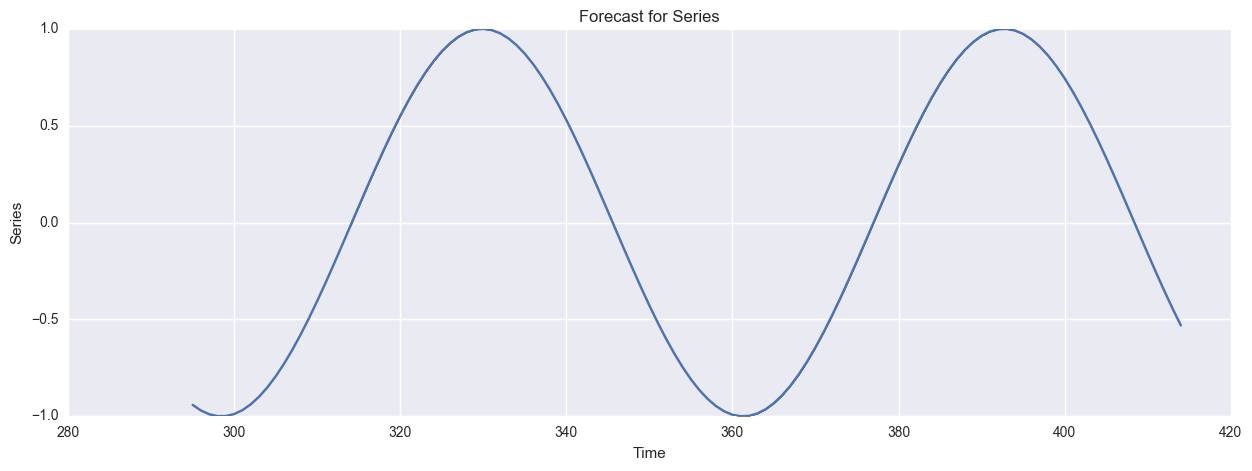

In [15]:
h = 100 # nbr of points to predict
past_values = 20 # nbr of past points to plot
model.plot_predict(h=h, past_values=past_values, figsize=(15,5), intervals=True)

# if the model is predicting correctly then we'll see peaks at approx 330 and 390)

### Build ARIMA model - `MA`

We build an moving-average-only (MA only) model, set to the value "where the ACF essentially becomes 0". https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins#Autocorrelation_and_partial_autocorrelation_plots 

NOTE FROM IAN - I DON'T KNOW WHAT SORT OF DATA SUITS USING `MA` - feedback welcomed. Possibly `32` makes sense as that's the point where the ACF first becomes `0` but I'm guessing that I've just misinterpreted this (since I don't know when the MA component should be used).

In [16]:
model = pf.ARIMA(data=y.values,ar=0,ma=2,integ=0)
fitted = model.fit()
fitted.summary()

ARIMA(0,0,2)                                                                                              
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 2                                           Log Likelihood: 46.5525                           
End Date: 314                                           AIC: -85.1051                                     
Number of observations: 313                             BIC: -70.1203                                     
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.1805     0.0542     3.3286   0.0009   (0.0742 | 0.2869)        
MA(1)                                

/home/ian/anaconda3/envs/rossmann/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:84: RuntimeWarning: overflow encountered in square
  return -x**2 / 2.0 - _norm_pdf_logC
/home/ian/anaconda3/envs/rossmann/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/home/ian/anaconda3/envs/rossmann/lib/python3.5/site-packages/numdifftools/core.py:946: RuntimeWarning: invalid value encountered in double_scalars
  f(x - ee[i, :] + ee[j, :], *args, **kwargs) +
/home/ian/anaconda3/envs/rossmann/lib/python3.5/site-packages/numdifftools/extrapolation.py:431: RuntimeWarning: invalid value encountered in less_equal
  converged = err <= tol
/home/ian/anaconda3/envs/rossmann/lib/python3.5/site-packages/numdifftools/limits.py:146: RuntimeWarning: invalid value encountered in less
  outliers = (((abs(der) < (a_median / trim_fact)) +
/home/ian/anaconda3/envs/rossmann/lib/python3

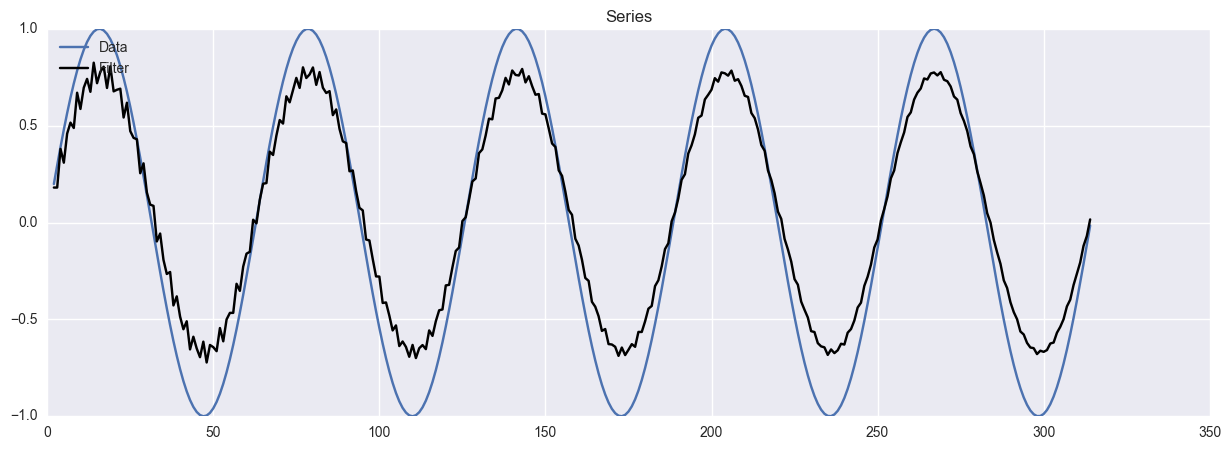

In [17]:
model.plot_fit(figsize=(15,5))

/home/ian/anaconda3/envs/rossmann/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


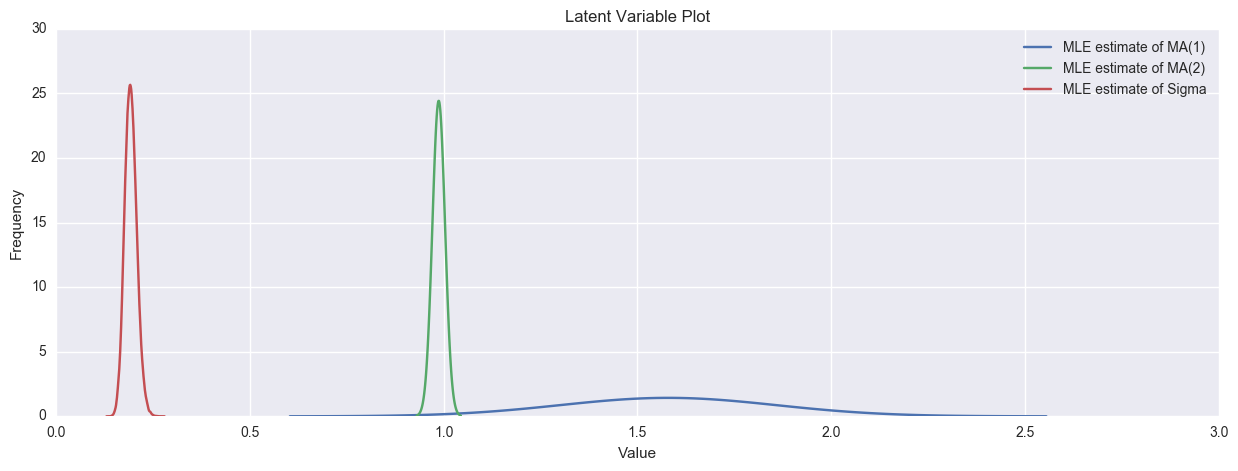

In [18]:
model.plot_z(indices=range(1,9))

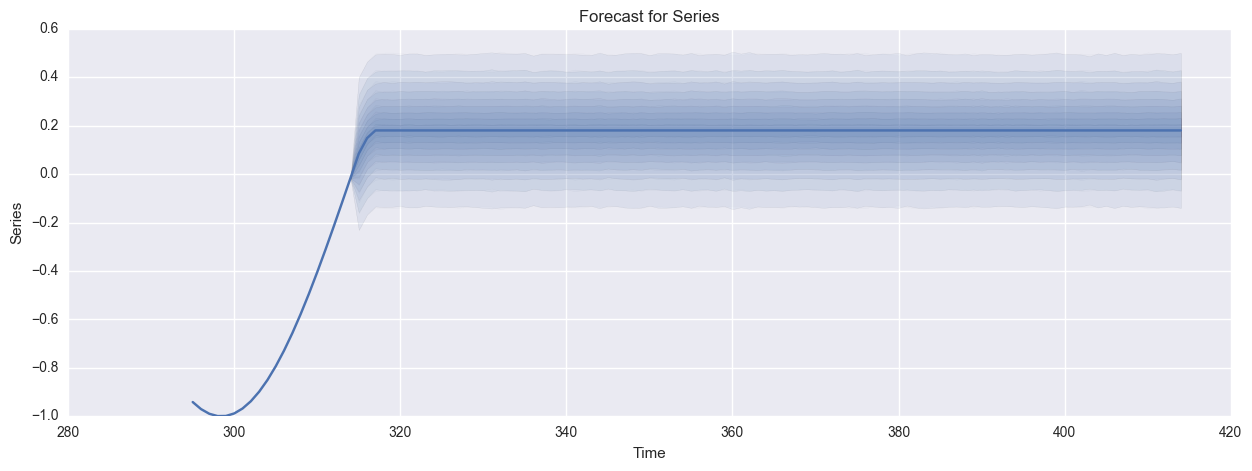

In [19]:
model.plot_predict(h=h, past_values=past_values, figsize=(15,5), intervals=True)

### Build ARIMA model - `I(1)`

We build an Integrative-only model with 1 coefficient if we have a trend.

Integrative means `y(t) = y(t) - y(t-1)`, it is the difference of current and previous value. It removes simple trends (and with more coefficients it can remove "more trends").

In [20]:
if USING_TREND:
    model = pf.ARIMA(data=y.values,ar=0,ma=0,integ=1)
    fitted = model.fit()
    fitted.summary()
    
    # note the y scale change
    model.plot_fit(figsize=(15,5))
    
    model.plot_predict_is(h=200,figsize=(15,5)) # in-sample rolling predictions
else:
    print("Not using a trend")

Not using a trend


### Build ARIMA model - `AR and I`

We build an auto-regressive and moving average (AR I only) model

In [21]:
if USING_TREND:
    model = pf.ARIMA(data=y.values,ar=2,ma=0,integ=1)
    fitted = model.fit()
    fitted.summary()

    model.plot_fit(figsize=(15,5))

    model.plot_predict_is(h=200,figsize=(15,5)) # in-sample rolling predictions

    model.plot_predict(h=h, past_values=past_values, figsize=(15,5), intervals=True)
    # if the model is predicting correctly then we'll see peaks at approx 330 and 390)